# Experimenting with ML models
In this notebook, I'm experimenting with a few different models, to see which might be the most favorable option

In [39]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest

In [2]:
# Read in data
path = '../data/guitars.csv'
guitars = pd.read_csv(path)

In [3]:
# Remove crazy outliers above $10,000
guitars = guitars.drop(index=guitars.loc[guitars['Price'] > 9999.99].index)

In [4]:
def wrangle(X):
    '''Bulk wrangle for split data'''
    
    # Avoid setting with copy
    X = X.copy()
    
    # Set feature thresholds
    model_limit = 50
    brand_limit = 50
    color_limit = 100
    material_limit = 50
    btype_limit = 30
    size_limit = 10
    pline_limit = 50
    
    # Clean conditions column text
    X['Condition'] = X['Condition'].str.replace('\:\D+', '')
    
    # Make null values out of the incorrectly entered categories
    conditions = ['Used', 'New', 'Open box', 'Seller refurbished',
                  'For parts or not working', 'Manufacturer refurbished']
    
    X.loc[~X['Condition'].isin(conditions), 'Condition'] = np.nan
    
    # Combine columns that are obviously the same and where values are null
    to_merge = {'Right-/ Left-Handed': ['Dexterity', 'Hand'],
                'Country/Region of Manufacture': ['Country of Manufacture'], 
                'Body Color': ['Color'], 'Body Type': ['Type']}
    for main_feat, dup_feat in to_merge.items():
        for f in dup_feat:
            condition = X[main_feat].isnull() & ~X[f].isnull()
            X.loc[condition, main_feat] = X[f]
            # Drop column after merge
        X = X.drop(columns=dup_feat)
    
    # TODO: fix right-left hand business
    # Reduce categories in the right-/ left hand column
    X['Orientation'] = X['Right-/ Left-Handed'].str.upper()
    X['Orientation'] = X['Orientation'].str.replace(
        '(RIGHT OR LEFT|LEFT OR RIGHT|EITHER|LAP|RIGHT-HANDED,).*', 
        'BOTH')
    X['Orientation'] = X['Orientation'].str.replace(
        'R.*', 'RIGHT-HANDED')
    X['Orientation'] = X['Orientation'].str.replace(
        'L.*', 'LEFT-HANDED')
    
    # Remove names that aren't real models from top 100
    X['Model'] = X['Model'].str.upper()
    not_a_model = ['DRN979CTV LH BK 2ND', '39" ELECTRIC GUITAR', '2019',
                   'DOES NOT APPLY', 'UNKNOWN', 'GTR235 LH BK 2ND']  
    top_models = X['Model'].value_counts()[:model_limit].index
    
    X.loc[X['Model'].isin(not_a_model), 'Model'] = 'OTHER'
    X.loc[~X['Model'].isin(top_models), 'Model'] = 'OTHER'
    
    # Clean and shrink the brand column
    X['Brand'] = X['Brand'].str.upper()
    X['Brand'] = X['Brand'].str.replace('UNBRANDED.*', 'UNBRANDED')
    top_brands = X['Brand'].value_counts()[:brand_limit].index
    X.loc[~X['Brand'].isin(top_brands), 'Brand'] = 'OTHER'
    
    # Clean and shrink cardinality of the string configuration column
    standard_configs = ['6 String', '7 String', '8 String', '9 String', '12 String']
    
    X['String Configuration'] = X['String Configuration'].str.upper()
    X['String Configuration'] = X['String Configuration'].str.replace(
        '6\W*STRING(?!78912).*|^6$|6\s*\w*\s*STRINGS(?!78912)', '6 STRING')
    X['String Configuration'] = X['String Configuration'].str.replace('^7$', '7 STRING')
    X['String Configuration'] = X['String Configuration'].str.replace('12\W*STRING', '12 STRING')
    
    X.loc[~X['String Configuration'].isin(standard_configs), 'String Configuration'] = 'OTHER'
    
    # Turn UPC and MPN into included and not included categories
    X['UPC'] = X['UPC'].str.upper()
    X.loc[X['UPC'] != 'DOES NOT APPLY', 'UPC'] = 'PROVIDED'
    X.loc[X['UPC'] == 'DOES NOT APPLY', 'UPC'] = 'NOT AVAILABLE'
    
    # If MPN entry contains a digit, it can be considered a valid entry
    mpn_condition = X['MPN'].str.contains('\d')
    X.loc[mpn_condition == True, 'MPN'] = 'PROVIDED'
    X.loc[mpn_condition == False, 'MPN'] = 'NOT AVAILABLE'
    
    # Reduce size, color and material and product line cardinality
    features_limits = {'Body Color': color_limit,
                       'Body Material': material_limit,
                       'Size': size_limit,
                       'Product Line': pline_limit}
    
    for feat, lim in features_limits.items(): # Apply the same wrangling to 3 features
        X[feat] = X[feat].str.upper()
        top = X[feat].value_counts()[:lim].index
        X.loc[~X[feat].isin(top), feat] = 'OTHER'
    
    # Reduce body type cardinality
    X['Body Type'] = X['Body Type'].str.upper()
    top_btypes = X['Body Type'].value_counts().index[:btype_limit]
    X['Body Type'].str.replace('STRAT.*', 'STRATOCASTER')
    X.loc[~X['Body Type'].isin(top_btypes), 'Body Type'] = 'OTHER'
    
    # Make model year a numeric category
    X.loc[X['Model Year'].str.contains('^\d{4}$') == False, 'Model Year'] = np.nan
    X['Model Year'] = pd.to_numeric(X['Model Year'])    
    
    return X

### Beginning With a Baseline
The mean absolute error produced by guessing will help to establish a baseline to begin improving upon. What is the mean absolute error produced by predicting the mean price for every sample

In [24]:
# Start with a baseline
error = guitars['Price'] - guitars['Price'].mean()
mae = error.abs().mean()
print(f'Mean Absolute Error: ${mae:.2f}')

Mean Absolute Error: $505.91


Off by $500 isn't terrible, but for some guitar sales on eBay, that may be completely off the mark, like in the case of guitars sold for ridiculously low prices, i.e. for parts or not working.

### Exploring ML models
Just for comparison's sake, I'm exploring the error produced by a few regression techniques with default parameters. 

In [5]:
# Split into train and test in preparation for cross-validation
train, test = train_test_split(guitars, train_size=0.8, random_state=42)

# Apply wrangling to train and test
train = wrangle(train)
test = wrangle(test)

In [6]:
train.shape, test.shape

((9956, 33), (2489, 33))

In [11]:
# Arrange data into X_train and y_train for CV
target = 'Price'
features = ['Model', 'MPN', 'Body Color', 'Brand', 
            'UPC', 'Body Material', 'Body Type', 
            'Model Year', 'Size', 'Country/Region of Manufacture',
            'String Configuration', 'Orientation', 
            'Product Line','Condition']
X_train = train[features]
y_train = train[target]

In [38]:
# Fit pipeline for a basic Linear Regression, get cross validated erro

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=40),
    LinearRegression()
)

k=3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean of {k} scores:', -scores.mean())

/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/jose/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jose/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jose/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/jose/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encoun

MAE for 3 folds: [389.41678633 378.89557351 390.92718173]
Mean of 3 scores: 386.41318052311885


An error of ~$390 is better than guessing, but not by enough. How does the error look with a random forest regressor?

In [46]:
# Fit pipeline for a random forest regressor, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k=5
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean of {k} scores:', -scores.mean())

MAE for 5 folds: [301.76091219 296.22328903 281.87790966 298.40733992 292.8445628 ]
Mean of 5 scores: 294.22280272198327


~$294 gets even closer, but it's likely that things can be done to get even closer still, without overfitting the data. The price column is heavily right skewed, so there is some log transformation in order.

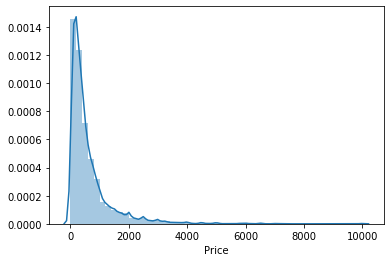

In [49]:
# Visualize skew in price
import seaborn as sns
sns.distplot(y_train);

### Log Transformation
If I log transorm the price, the distribution looks a little more normal

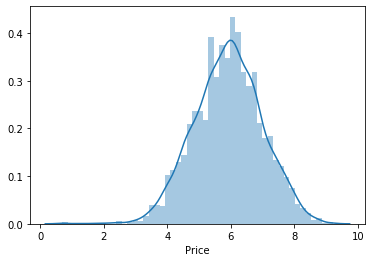

In [51]:
y_log = np.log1p(y_train)
sns.distplot(y_log);

Does the baseline error improve after this transformation?

In [63]:
error = y_log - y_log.mean()
mae_transformed = error.abs().mean()

# Untransform mae
mae = np.expm1(mae_transformed)
print(f'Mean Absolute Error of Log Transformed y: ${mae:.2f}')

Mean Absolute Error of Log Transformed y: $1.35


After transformation, the baseline gets down to less than $2 of error. Does that mean that the models tried before will do much better than before with a log transformed price?

In [65]:
# Fit pipeline for a basic Linear Regression, get cross validated erro

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=40),
    LinearRegression()
)

k=3
scores = cross_val_score(pipeline, X_train, y_log, cv=k,
                         scoring='neg_mean_absolute_error')
scores_untransformed = np.expm1(scores)
print(f'MAE for {k} folds:', -scores_untransformed)
print(f'Mean of {k} scores:', -scores_untransformed.mean())

/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/jose/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jose/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jose/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/jose/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encoun

MAE for 3 folds: [0.46712178 0.46091108 0.4706014 ]
Mean of 3 scores: 0.4662114217673827


Now the linear regression model's error is down below $1

In [66]:
# Fit pipeline for a random forest regressor, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k=5
scores = cross_val_score(pipeline, X_train, y_log, cv=k,
                         scoring='neg_mean_absolute_error')
scores_untransformed = np.expm1(scores)
print(f'MAE for {k} folds:', -scores_untransformed)
print(f'Mean of {k} scores:', -scores_untransformed.mean())

MAE for 5 folds: [0.38476705 0.38921204 0.37931688 0.38937286 0.38987671]
Mean of 5 scores: 0.38650910761729335


### XGBoost and Permutation Importance

In [12]:
X_train['Orientation'].value_counts()

RIGHT-HANDED    7483
LEFT-HANDED      260
BOTH              10
Name: Orientation, dtype: int64